Intensity vs Fermi Chopper frequency

Just try the original parameters

In [2]:
workdir = '~/dv/sns-chops/resolution/CNCS/mcvine'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine


In [3]:
import numpy as np, os, sys, glob
from matplotlib import pyplot as plt

import histogram.hdf as hh, histogram as H
import mcvine, mcvine.components
from mcni.utils import conversion as C

from matplotlib import pyplot as plt
%matplotlib notebook

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Explore

In [4]:
distance = 1.
emin, emax = 5, 5.005
eave = (emin+emax)/2
v = C.e2v(eave)
tof = distance/v

instrument = mcvine.instrument()
source = mcvine.components.sources.SNS_source(
    'source', 
    S_filename='./a1Gw2-5-f5.dat', width=0.1, height=0.12, dist=0.98,
    xw=0.06, yh=0.11, Emin=emin, Emax=emax)
instrument.append(source, position=(0,0,0))

monitor = mcvine.components.monitors.TOF_monitor2(
    'monitor', filename='Itof.dat', xmin=-0.04, xmax=0.04, ymin=-0.06, ymax=0.06, tmin=tof*.9, tmax=tof*2)
instrument.append(monitor, position=(0,0,1))

In [5]:
%%time
# quick sim
neutrons = instrument.simulate(int(1e3),outputdir="out", overwrite_datafiles=True, iteration_no=0)

CPU times: user 123 ms, sys: 34.9 ms, total: 158 ms
Wall time: 343 ms


In [6]:
len(neutrons)

1000

In [7]:
ls 

a1Gw2-5-f5.dat     beam-fwhms-SNS_source_r1.txt  Itof.dat
beam-fc-fwhms.txt  beam-fwhms.txt                out/


In [8]:
ls out/step0/

Itof.h5  number_of_mc_samples


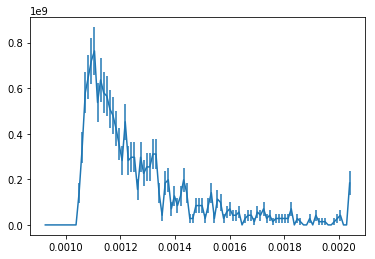

In [9]:
H.plot(hh.load('./out/step0/Itof.h5'))

# Loop

In [10]:
def calculatePulseShape(E, ncount=1e4):
    distance = 1.
    emin, emax = E*0.999, E*1.001
    eave = (emin+emax)/2
    v = C.e2v(eave)
    tof = distance/v

    instrument = mcvine.instrument()
    source = mcvine.components.sources.SNS_source(
        'source', 
        S_filename='./a1Gw2-5-f5.dat', width=0.1, height=0.12, dist=0.98,
        xw=0.06, yh=0.11, Emin=emin, Emax=emax)
    instrument.append(source, position=(0,0,0))

    monitor = mcvine.components.monitors.TOF_monitor2(
        'monitor', filename='Itof.dat', xmin=-0.04, xmax=0.04, ymin=-0.06, ymax=0.06, tmin=tof*.9, tmax=tof*2.2,
        nchan = 500,
    )
    instrument.append(monitor, position=(0,0,1))
    #
    instrument.simulate(int(ncount),outputdir="out", overwrite_datafiles=True, iteration_no=0)
    return hh.load('./out/step0/Itof.h5')

In [11]:
h = calculatePulseShape(20., ncount=2e5)

<IPython.core.display.Javascript object>


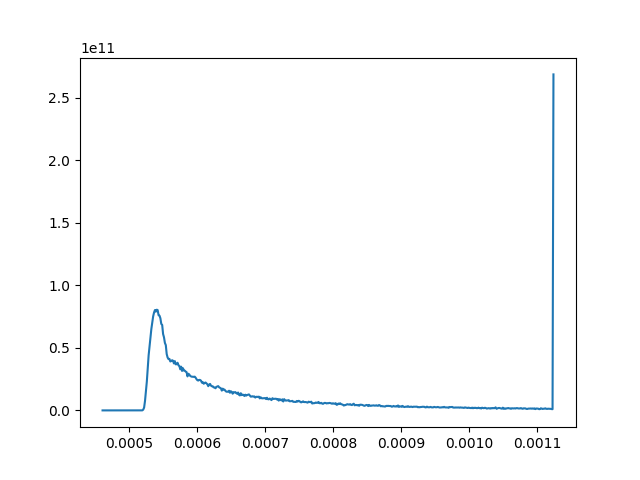

In [16]:
plt.figure()
plt.plot(h.tof, h.I)

In [17]:
Es = np.logspace(-1, 2)

In [18]:
import tqdm

In [19]:
spectra = []
for E in tqdm.tqdm(Es):
    spectra.append(calculatePulseShape(E, ncount=4e5))

100%|██████████| 50/50 [05:34<00:00,  6.52s/it]


In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


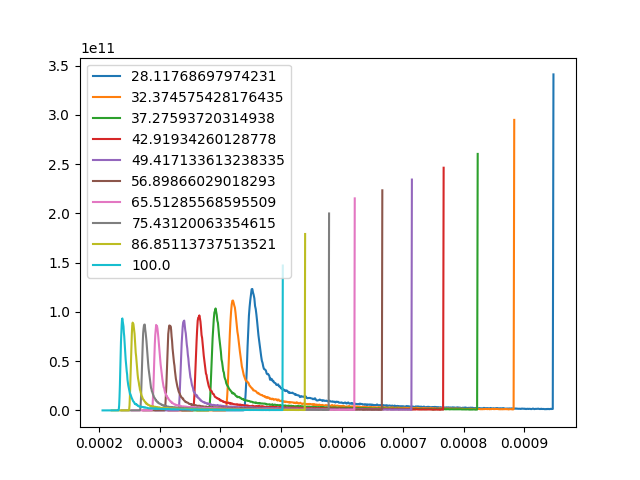

In [20]:
plt.figure()
for E, sp in zip(Es, spectra)[40:50]:
    plt.plot(sp.tof, sp.I, label=E)
plt.legend()

In [21]:
fwhms = []
for E, sp in zip(Es, spectra):
    I = sp.I[:-5]; tof = sp.tof[:-5]
    max = I.max()
    hm = max/2
    top = tof[I>hm]
    fwhms.append(top[-1]-top[0])

In [22]:
fwhms = np.array(fwhms)

In [23]:
np.savetxt('beam-fwhms.txt', np.array([Es, fwhms]).T)

<IPython.core.display.Javascript object>


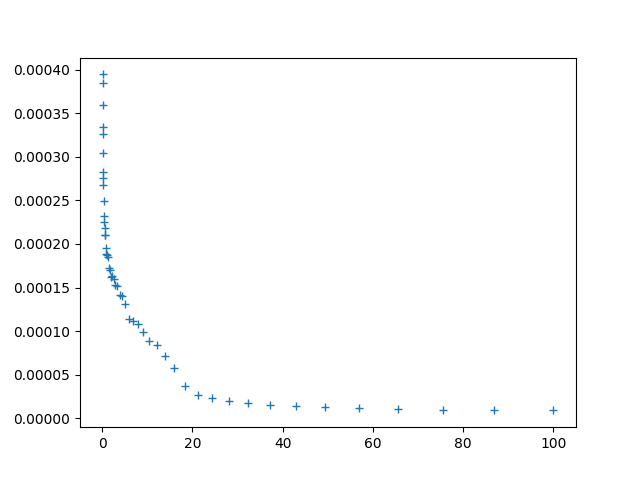

In [24]:
plt.figure()
plt.plot(Es, fwhms, '+')

<IPython.core.display.Javascript object>


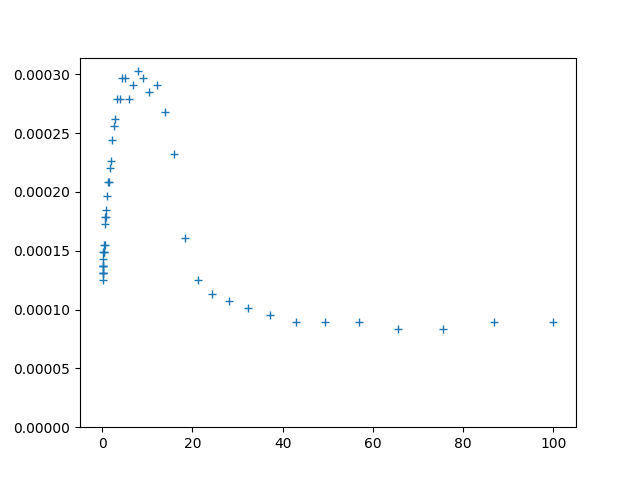

(0, 0.0003141566084538654)

In [25]:
plt.figure()
plt.plot(Es, fwhms*np.sqrt(Es), '+')
plt.ylim(0, None)

In [105]:
wavelens = 2*np.pi/conversion.e2k(Es)

<IPython.core.display.Javascript object>


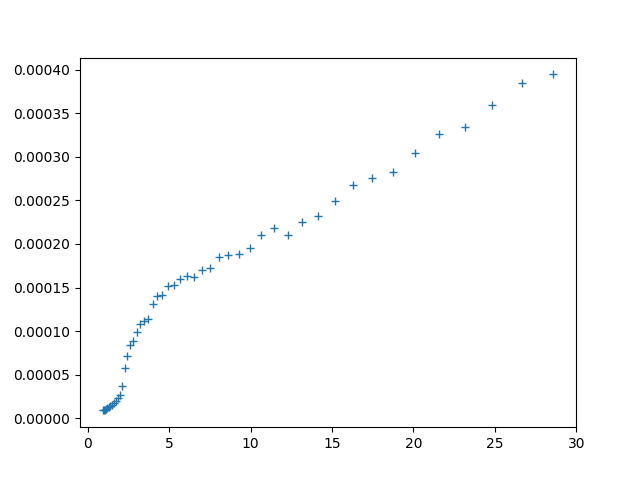

In [107]:
plt.figure()
plt.plot(wavelens, fwhms, '+')

In [111]:
print repr(wavelens)

array([28.60141458, 26.65479018, 24.84065387, 23.14998844, 21.57439041,
       20.10602826, 18.73760346, 17.46231422, 16.27382172, 15.16621852,
       14.13399926, 13.17203328, 12.27553911, 11.44006072, 10.66144534,
        9.93582285,  9.25958654,  8.62937515,  8.04205622,  7.49471047,
        6.9846173 ,  6.50924128,  6.06621956,  5.65335009,  5.26858069,
        4.90999885,  4.57582225,  4.26438985,  3.97415367,  3.70367109,
        3.45159766,  3.21668046,  2.99775183,  2.79372357,  2.60358156,
        2.42638069,  2.2612402 ,  2.10733923,  1.96391283,  1.83024809,
        1.70568063,  1.58959128,  1.48140303,  1.38057811,  1.28661538,
        1.19904779,  1.11744009,  1.04138664,  0.97050943,  0.90445614])


In [112]:
print repr(fwhms*1e6)

array([394.74851313, 385.39994119, 359.16945787, 334.72423237,
       326.1219756 , 303.92597574, 283.24064504, 275.43982613,
       267.38882796, 249.19023102, 232.2302383 , 225.08153186,
       209.76238742, 218.04193242, 210.20886838, 195.90196372,
       188.65441948, 187.15739199, 184.99025213, 172.39973718,
       169.84706018, 162.56522965, 163.46157422, 159.76734973,
       152.35615612, 151.66764509, 141.34508089, 140.13305828,
       130.59554295, 114.40472566, 111.15524013, 107.81812931,
        98.50978602,  88.13296151,  83.8457322 ,  71.76044951,
        57.95954918,  37.39485995,  27.10536106,  22.85479121,
        20.17826946,  17.76020967,  15.57782803,  13.6102448 ,
        12.68392577,  11.8206524 ,  10.28172487,   9.58194632,
         9.56763749,   8.91646003])


# Fit

In [26]:
sys.path.insert(0, "/SNS/users/lj7/dv")

In [27]:
from PyChop import Chop

In [28]:
fit = 0.000305*np.exp(-Es/5)+5e-6

<IPython.core.display.Javascript object>


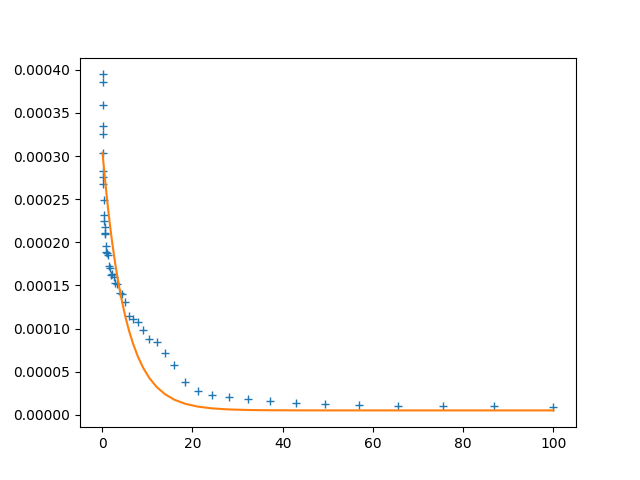

In [29]:
plt.figure()
plt.plot(Es, fwhms, '+')
plt.plot(Es, fit)

In [30]:
from scipy.signal import savgol_filter

In [31]:
len(fwhms)

50

<IPython.core.display.Javascript object>


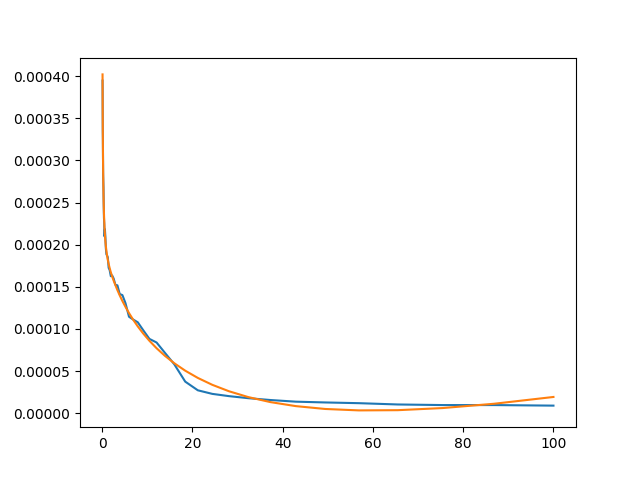

In [32]:
plt.figure()
plt.plot(Es, fwhms)
plt.plot(Es, savgol_filter(fwhms, 49, 5))

## PyChop polyval model seems ok

In [33]:
import PyChop.Instruments

In [34]:
np.sqrt(PyChop.Instruments.E2L / 100.)

0.9044567962971772

In [35]:
from mcni.utils import conversion

In [36]:
2*np.pi/conversion.e2k(100.)

0.9044561436553435

In [37]:
wavelens = 2*np.pi/conversion.e2k(Es)

In [102]:
coeffs = np.polyfit(wavelens, fwhms*1e6, 16)

In [103]:
f = np.poly1d(coeffs)

<IPython.core.display.Javascript object>


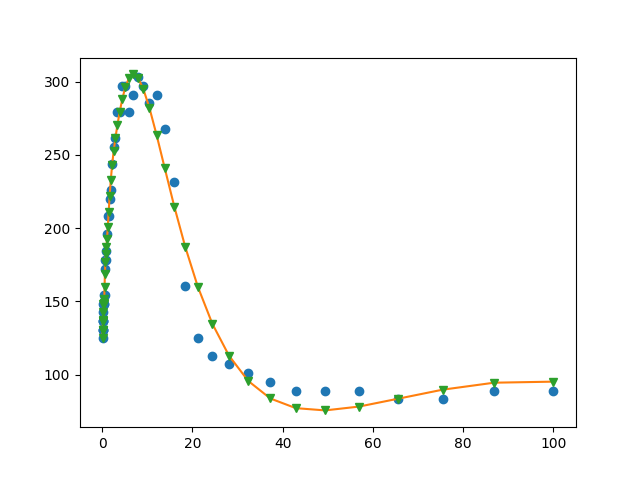

In [104]:
plt.figure()
plt.plot(Es, fwhms*np.sqrt(Es)*1e6, 'o')
plt.plot(Es, f(wavelens)*np.sqrt(Es), '-')
plt.plot(Es, np.polyval(coeffs, wavelens)*np.sqrt(Es), 'v')

<IPython.core.display.Javascript object>


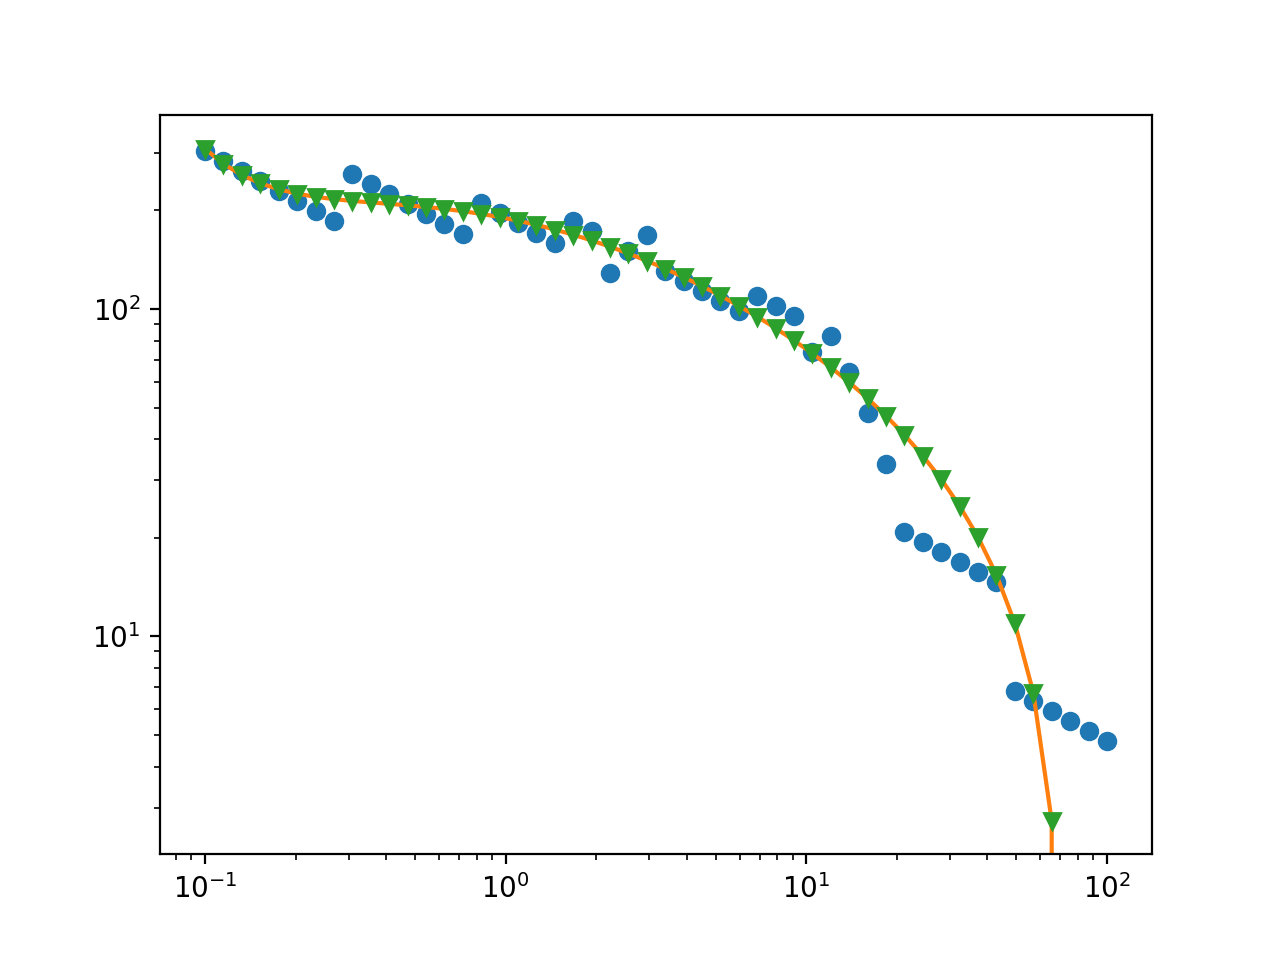

In [276]:
plt.figure()
plt.loglog(Es, fwhms*1e6, 'o')
plt.loglog(Es, f(wavelens), '-')
plt.loglog(Es, np.polyval(coeffs, wavelens), 'v')

In [275]:
coeffs

array([  6.48651580e-05,  -6.22810648e-03,   2.63103296e-01,
        -5.63287618e+00,   6.10327306e+01,  -5.87906885e+01])

## Other models

<IPython.core.display.Javascript object>


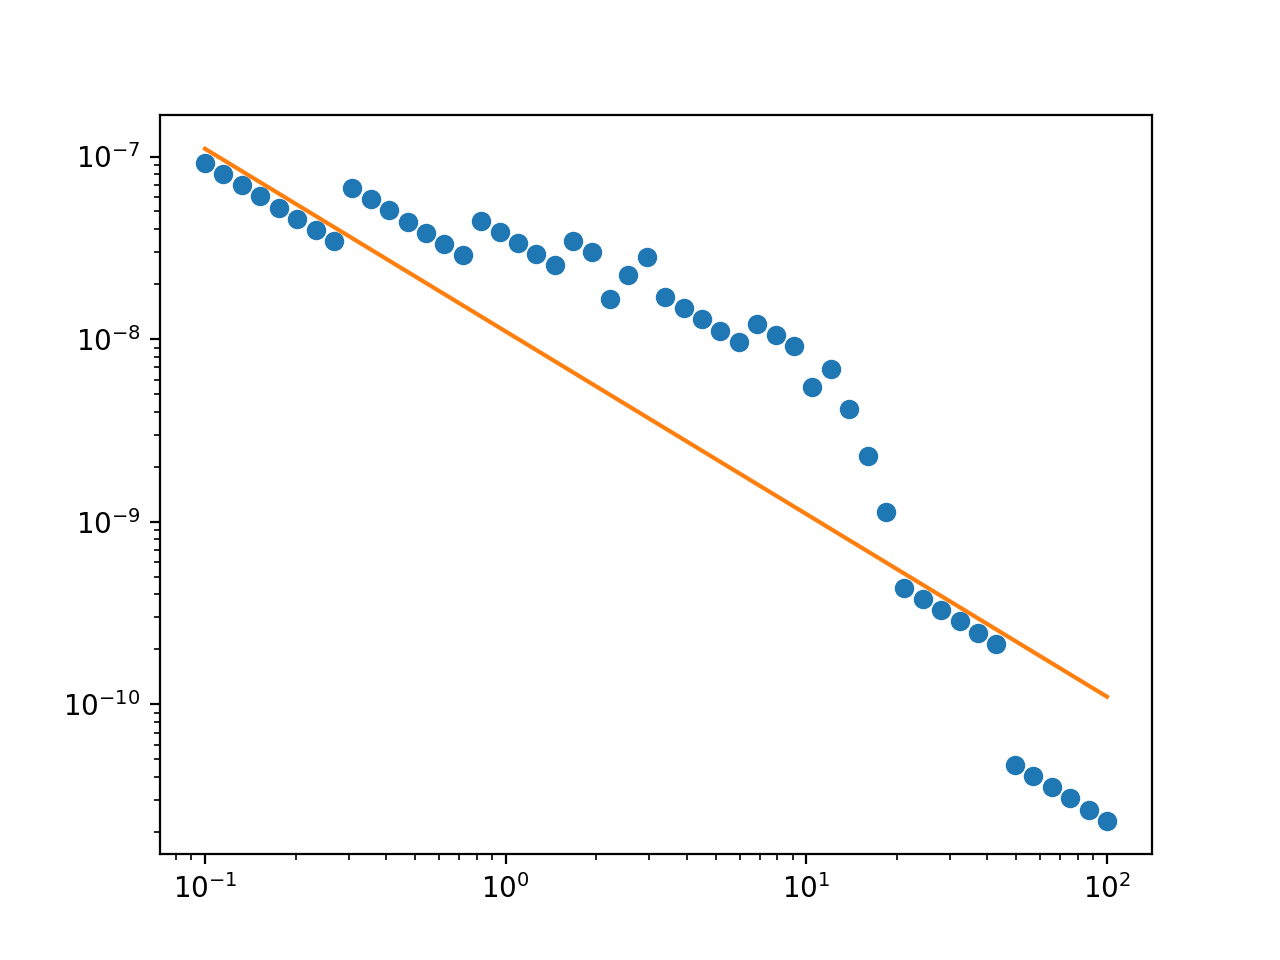

In [211]:
plt.figure()
plt.loglog(Es, fwhms**2, 'o')
plt.loglog(Es, Chop.tchi(.09, Es))

<IPython.core.display.Javascript object>


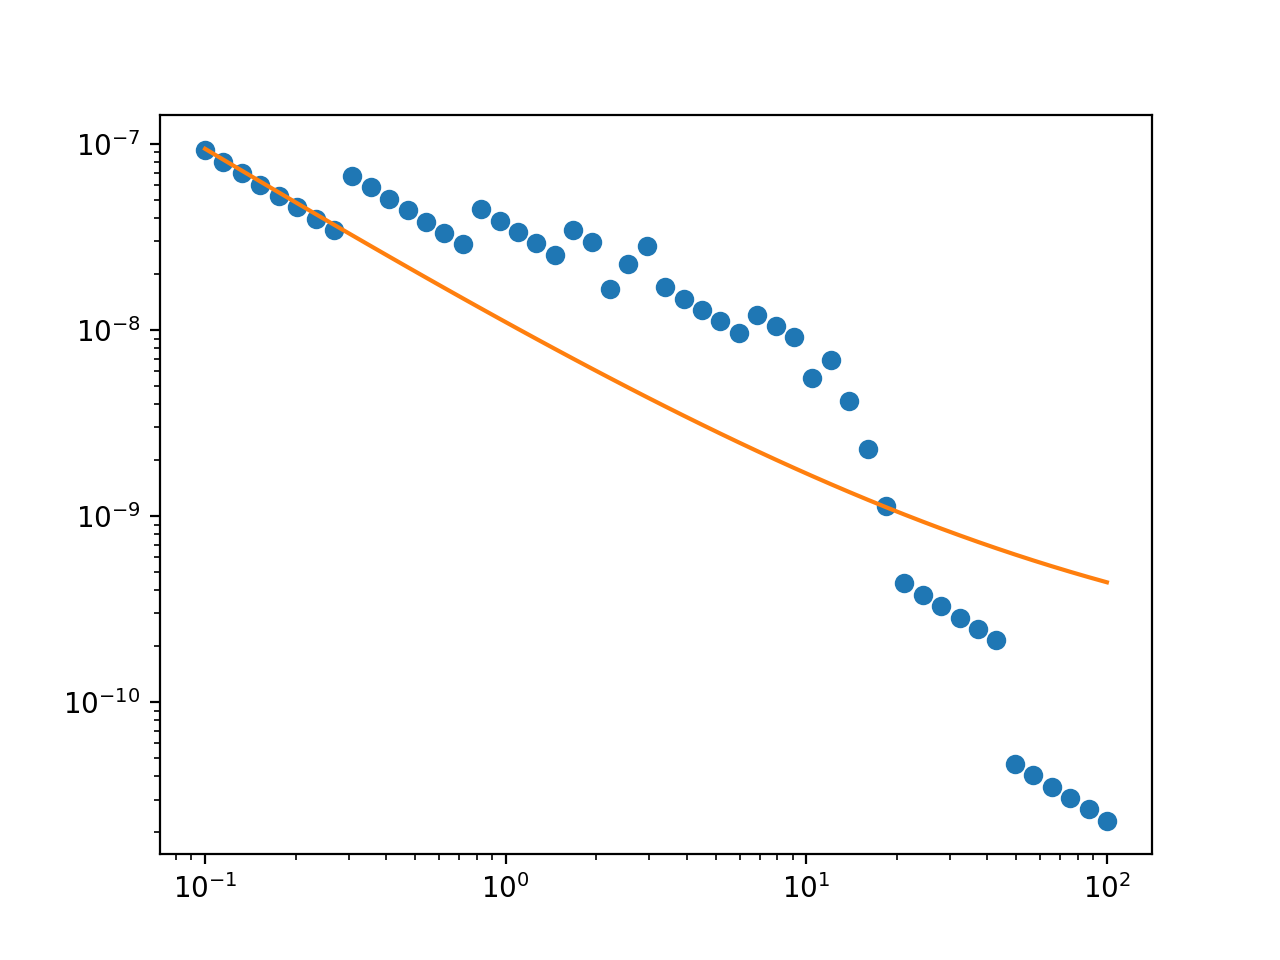

In [212]:
plt.figure()
plt.loglog(Es, fwhms**2, 'o')
plt.loglog(Es, Chop.tchi_2(.08, .01, Es))

In [233]:
np.interp?